# Tarvel Review Ratings

Google reviews on attractions from 24 categories across Europe are considered. Google user rating ranges from 1 to 5 and average user rating per category is calculated.

## Goal

To predict how will user give a review to a location from other infomations.

## Attribute Information

For each attribute, the first is the unique id for each uesr. The others are how the user rating a category for a location on average

The values ranges from 0.00 to 5.00 actually, not 1.00 to 5.00 for it's original discription.

for detailed information for each attribute, please refer to this website: https://archive.ics.uci.edu/ml/datasets/Tarvel+Review+Ratings

I will rename the attribute later.

There are totally 5456 data

## Approaches

I will use the former 23 categories as feature, the last category is the thing I would used to cluster people alike

that is, the last category (gardens) is the goal we want to cluster people into several (maybe 6) groups

and how they rate the other 23 categories is the features to train.

However, the original value seems to be too discrete, I shall divide them into several parts

## Preprocessing



In [154]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn import metrics, model_selection, svm

In [156]:
# loading file
filename = 'google_review_ratings.csv'
data = pd.read_csv(filename)
# there are \"Unnamed: 25\" colume somehow, it's NaN so it sould be dropped
# user ID is not needed here too, so drop it as well
data = data.drop(["User", "Unnamed: 25"],axis=1)
attributes = [
    'churches', 'resorts', 'beaches', 'parks', 'theatres', 'museums',
    'malls', 'zoo', 'restaurants', 'pubs/bars', 'local services', 'burger/pizza shops',
    'hotels/other lodgings', 'juice bars', 'art galleries', 'dance clubs', 'swimming pools', 'gyms', 
    'bakeries', 'beauty & spas', 'cafes', 'view points', 'monuments', 'gardens',
]
data.columns = attributes

# data = data.astype(np.float64)  # There are some columns are NOT float64, so I need to converte them
# I gave up, there are corrupted data in local service and I don't know how to fix it, so I just drop it
# I got error message: ValueError: could not convert string to float: '2\t2.'

data=data.drop(["local services"],axis=1)
data = data.astype(np.float64)

data.head()

,churches,resorts,beaches,parks,theatres,museums,malls,zoo,restaurants,pubs/bars,...,art galleries,dance clubs,swimming pools,gyms,bakeries,beauty & spas,cafes,view points,monuments,gardens
0,0.0,0.0,3.63,3.65,5.0,2.92,5.0,2.35,2.33,2.64,...,1.74,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,3.63,3.65,5.0,2.92,5.0,2.64,2.33,2.65,...,1.74,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,3.63,3.63,5.0,2.92,5.0,2.64,2.33,2.64,...,1.74,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0
3,0.0,0.5,3.63,3.63,5.0,2.92,5.0,2.35,2.33,2.64,...,1.74,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,3.63,3.63,5.0,2.92,5.0,2.64,2.33,2.64,...,1.74,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0


In [171]:
# I got value error while applying svm below, so I turn back to try to fix it
# ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

print('Is there any NaN?  {tf}'.format(tf=np.any(np.isnan(data))))
print('Is there any Inf?  {tf}'.format(tf=np.all(np.isfinite(data))))

data[np.isnan(data) == True] = 0

print('Is there any NaN?  {tf}'.format(tf=np.any(np.isnan(data))))

# See if I fix it
# I think yes

Is there any NaN?  True
Is there any Inf?  False
Is there any NaN?  False


In [172]:
# spliting dataset

# the graden is too discrete for SVM, see explaination for this apporach below
for i in range(len(data)):
    if data['gardens'][i] < 1.00:
        data['gardens'][i] = 0
    elif data['gardens'][i] > 1.00 and data['gardens'][i] < 2.00:
        data['gardens'][i] = 1
    elif data['gardens'][i] > 2.00 and data['gardens'][i] < 3.00:
        data['gardens'][i] = 2
    elif data['gardens'][i] > 3.00 and data['gardens'][i] < 4.00:
        data['gardens'][i] = 3
    elif data['gardens'][i] > 4.00 and data['gardens'][i] < 5.00:
        data['gardens'][i] = 4

np.random.seed(0) # use random seed to control spliting dataset to achieve reproducibility
train, test = model_selection.train_test_split(data) 
# test size is 0.25 by default and the rest is for training, not sure if I should change it

def split(data):
    x_data = data.loc[:, data.columns != 'gardens']
    y_data = data['gardens']
    return x_data, y_data

x_train, y_train = split(train)
x_test, y_test = split(test)

In [158]:
# evaluation function for training results
def evaluate(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)

    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)

    train_acc = metrics.accuracy_score(y_train, train_predict)
    test_acc = metrics.accuracy_score(y_test, test_predict)

    return train_acc, test_acc

## Clustering

Using SVM to try to cluster people by the how they give rating to places.

Some categories are related to others, and people who loves a specific category would probably give high rating to places alike.

but first of all, we need to split them into 6 groups or we can't apply SVM

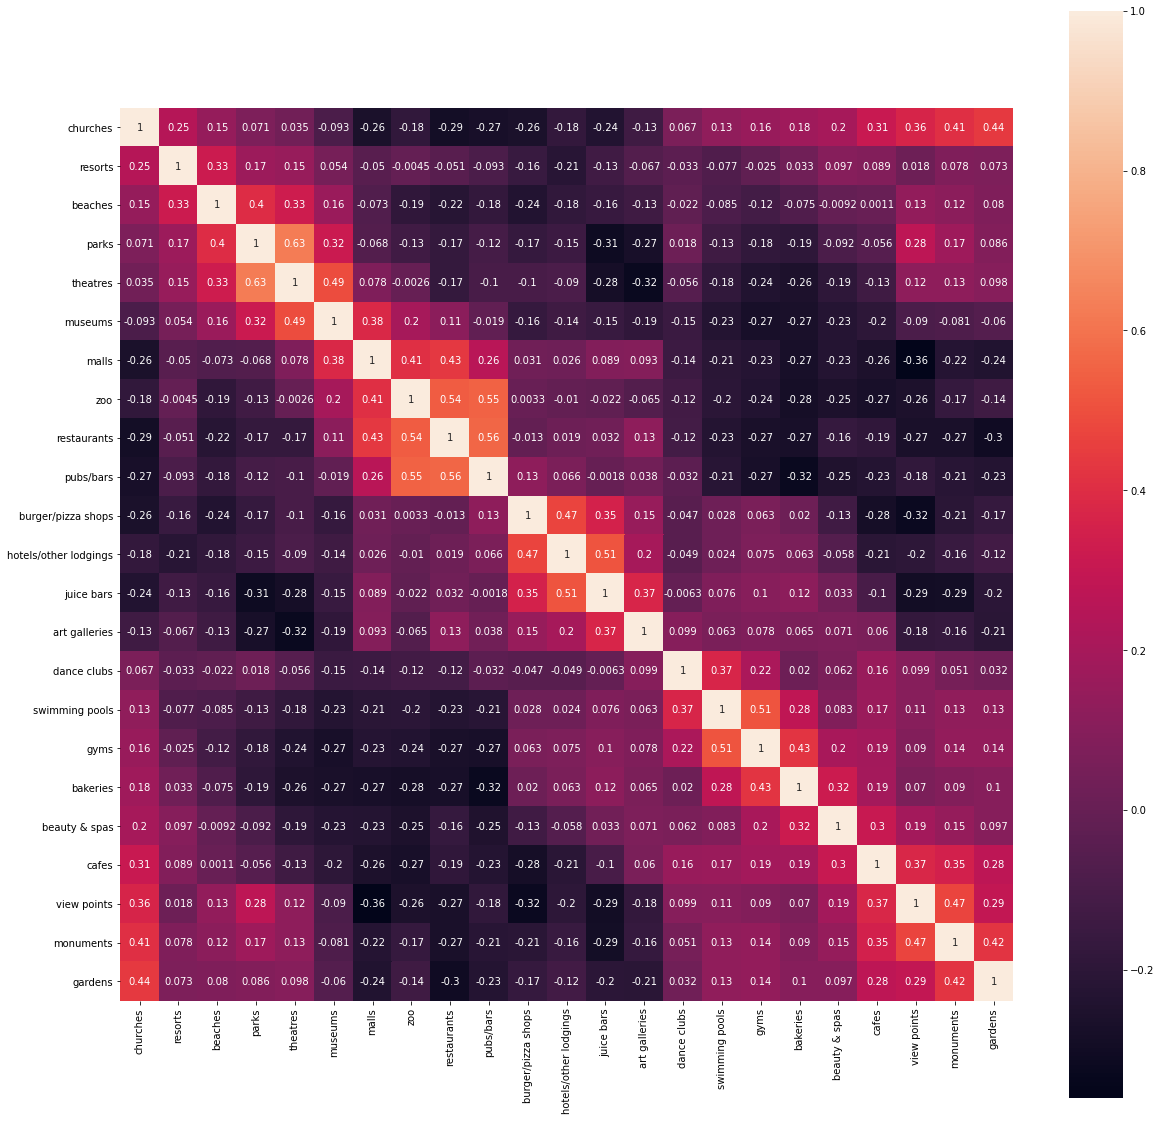

In [152]:
import seaborn as sb
plt.figure(figsize=(20,20))
heatmap = sb.heatmap(data.corr(), square=True, annot=True)
plt.show() # you can see there is correlations between each category

In [184]:
clf = svm.SVC(kernel='linear')
train_acc, test_acc = evaluate(clf, x_train, y_train, x_test, y_test)

print('----Linear kernel----')
print('Training accuracy: ' + str(train_acc))
print('Testing accuracy: ' + str(test_acc))

----Linear kernel----
Training accuracy: 0.8159824046920822
Testing accuracy: 0.8335777126099707


Though there are 80% acc. But maybe in this case, linear module is not really suitable

Trying out other kernels

In [179]:
clf = svm.SVC(kernel='poly')
train_acc, test_acc = evaluate(clf, x_train, y_train, x_test, y_test)

print('----Poly kernel----')
print('Training accuracy: ' + str(train_acc))
print('Testing accuracy: ' + str(test_acc))

----Poly kernel----
Training accuracy: 0.9098240469208211
Testing accuracy: 0.874633431085044


In [181]:
clf = svm.SVC(kernel='rbf')
train_acc, test_acc = evaluate(clf, x_train, y_train, x_test, y_test)

print('----rbf kernel----')
print('Training accuracy: ' + str(train_acc))
print('Testing accuracy: ' + str(test_acc))

----rbf kernel----
Training accuracy: 0.8707233626588465
Testing accuracy: 0.8687683284457478


In [183]:
clf = svm.SVC(kernel='sigmoid')
train_acc, test_acc = evaluate(clf, x_train, y_train, x_test, y_test)

print('----sigmoid kernel----')
print('Training accuracy: ' + str(train_acc))
print('Testing accuracy: ' + str(test_acc))

----rbf kernel----
Training accuracy: 0.5080645161290323
Testing accuracy: 0.4706744868035191


we can see there is a lot of improvement on poly kernel, while rbf is a bit weaker than poly

this might because the separation of the data is not so extreme, and the relation between data is not really strong

and thus poly kernel can cluster them better

therefore I choose poly kernel to see if there is further improvement

In [182]:
clf = svm.SVC(kernel="poly", degree=4)
train_acc, test_acc = evaluate(clf, x_train, y_train, x_test, y_test)

print('----Poly kernel----')
print('Training accuracy: ' + str(train_acc))
print('Testing accuracy: ' + str(test_acc))

----Poly kernel----
Training accuracy: 0.9403714565004888
Testing accuracy: 0.8819648093841642
